In [169]:
import torch
from torchinfo import summary
from tqdm import tqdm
import TorchData
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [170]:
import importlib
importlib.reload(TorchData)

<module 'TorchData' from 'F:\\projects\\ResearchProject\\TorchData\\__init__.py'>

In [171]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [198]:
NUM_DATA = 1024
BATCH_SIZE = 256
EPOCH = 100

In [199]:
train_dataset = TorchData.TORCHDataset2Channel(num_data=NUM_DATA)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

In [172]:
test_dataset = TorchData.TORCHDataset2Channel(num_data=1024)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

In [173]:
class ConvolutionAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 2, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [202]:
model = ConvolutionAutoencoder()
model = torch.nn.DataParallel(model)
model = model.to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [194]:
summary(model, input_size=(1, 2, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [1, 2, 120, 92]           --
├─ConvolutionAutoencoder: 1-1            [1, 2, 120, 92]           --
│    └─Sequential: 2-1                   [1, 8, 114, 86]           --
│    │    └─Conv2d: 3-1                  [1, 64, 118, 90]          1,216
│    │    └─BatchNorm2d: 3-2             [1, 64, 118, 90]          128
│    │    └─ReLU: 3-3                    [1, 64, 118, 90]          --
│    │    └─Conv2d: 3-4                  [1, 16, 116, 88]          9,232
│    │    └─BatchNorm2d: 3-5             [1, 16, 116, 88]          32
│    │    └─ReLU: 3-6                    [1, 16, 116, 88]          --
│    │    └─Conv2d: 3-7                  [1, 8, 114, 86]           1,160
│    │    └─BatchNorm2d: 3-8             [1, 8, 114, 86]           16
│    │    └─ReLU: 3-9                    [1, 8, 114, 86]           --
│    └─Sequential: 2-2                   [1, 2, 120, 92]           --
│    

In [203]:
for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()
        outputs = model(x.to(device))
        loss = loss_function(outputs, y.to(device))
        loss.backward()
        optimiser.step()

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [31]:
torch.save(model.state_dict(), f"Conv2Channel_{NUM_DATA}_{BATCH_SIZE}_{EPOCH}.pth")

In [204]:
### Using pretrained weights
model.load_state_dict(torch.load("ModelWeights/Conv2Channel/Conv2Channel_5096_512_3000.pth"))

<All keys matched successfully>

In [205]:
model.eval()
with torch.no_grad():
    all_pred = model.to("cpu")(test_dataset.x.to("cpu"))

all_pred_binary = all_pred[:, 0].unsqueeze(1)
all_pred_binary /= all_pred_binary.max()
all_pred_binary = torch.where(all_pred_binary < 0.5, 0, 1)
all_pred_time = all_pred[:, 1].unsqueeze(1) * test_dataset.sn_time.squeeze(0)
all_pred_time[all_pred_time < 0.5] = 0
all_pred_combined = all_pred_binary * all_pred_time

Text(0.5, 0.92, 'Combined Image')

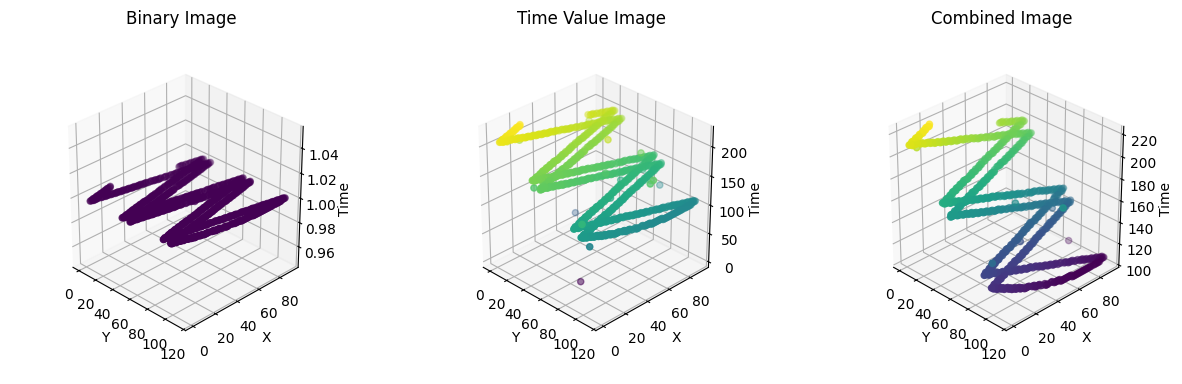

In [206]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})
TorchData.visual.plot3d(all_pred_binary[0], ax[0])
ax[0].set_title("Binary Image")
TorchData.visual.plot3d(all_pred_time[0], ax[1])
ax[1].set_title("Time Value Image")
TorchData.visual.plot3d(all_pred_combined[0], ax[2])
ax[2].set_title("Combined Image")

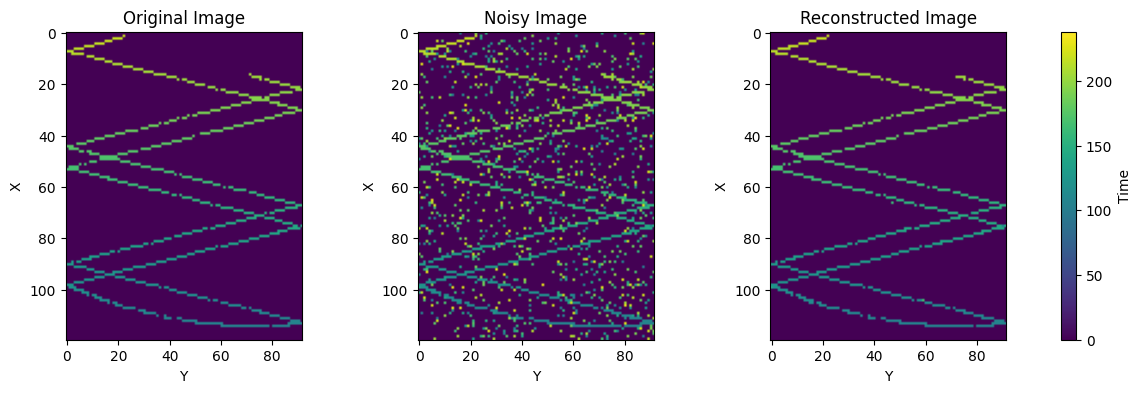

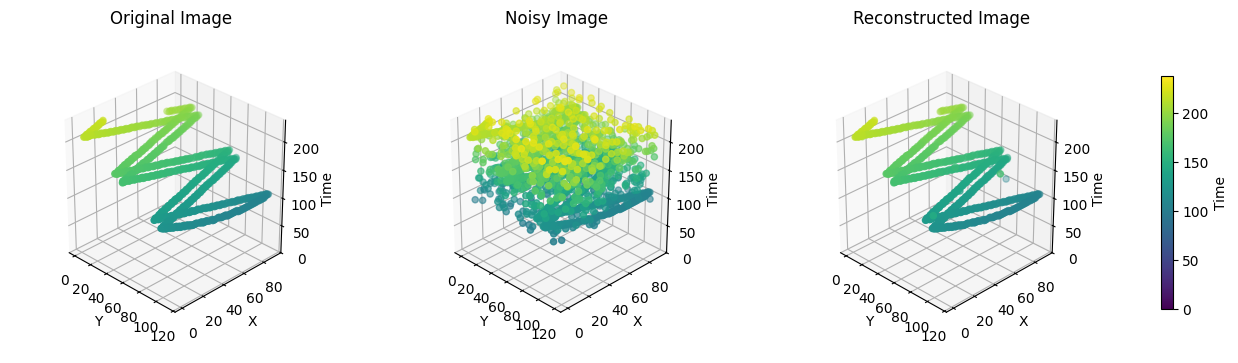

In [207]:
TorchData.visual.fast_compare_plot(test_dataset, all_pred_combined, 0)

In [208]:
pred_list = [
    {"name": "Time Value Image", "data": all_pred_time},
    {"name": "Combined Image", "data": all_pred_combined}
]
for i in pred_list:
    print(f"Metrics for {i['name']}:")
    mse = TorchData.metric.calculate_mse_torch(test_dataset.signal_time, i["data"])
    psnr = TorchData.metric.calculate_psnr_torch(test_dataset.signal_time, i["data"])
    ssim = TorchData.metric.calculate_ssim_torch(test_dataset.signal_time, i["data"])
    roc_auc = roc_auc_score(test_dataset.signal.flatten().numpy(), i["data"].flatten().numpy())
    print(f"MSE: {mse:.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, ROC AUC: {roc_auc:.4f}")

Metrics for Time Value Image:
MSE: 41.6020, PSNR: 30.6573, SSIM: 0.9704, ROC AUC: 0.9991
Metrics for Combined Image:
MSE: 21.5603, PSNR: 33.5119, SSIM: 0.9876, ROC AUC: 0.9973
